In [4]:
# Import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline  # 需在文件开头导入
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay,roc_auc_score,roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance


%matplotlib inline

In [5]:
#Read the csv into pandas dataframe
data = pd.read_csv('../data/cardio_train.csv', sep=';')

#check the first contents of the data检查数据的前几行
data.head()

# 检查数据的类型和列的完整性check the data types and completeness of the columns data
data.info()

# 显示数据的统计信息Show the statistics of the data
data.iloc[:, 1:].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
#修改年龄从天到年，并重命名增加可读性

# Converting age from days to years for better understanding and analysis
data['age'] = data['age'] / 365.25
# Display age column
data.age

#Rename the columns for better understanding
data = data.rename(columns={'ap_hi': 'systolic_b_pressure'})
data = data.rename(columns={'ap_lo': 'diastolic_b_pressure'})
data = data.rename(columns={'gluc': 'glucose'})
data = data.rename(columns={'alco': 'alcohol'})
data = data.rename(columns={'active': 'physically_active'})
data = data.rename(columns={'cardio': 'cardio_disease'})

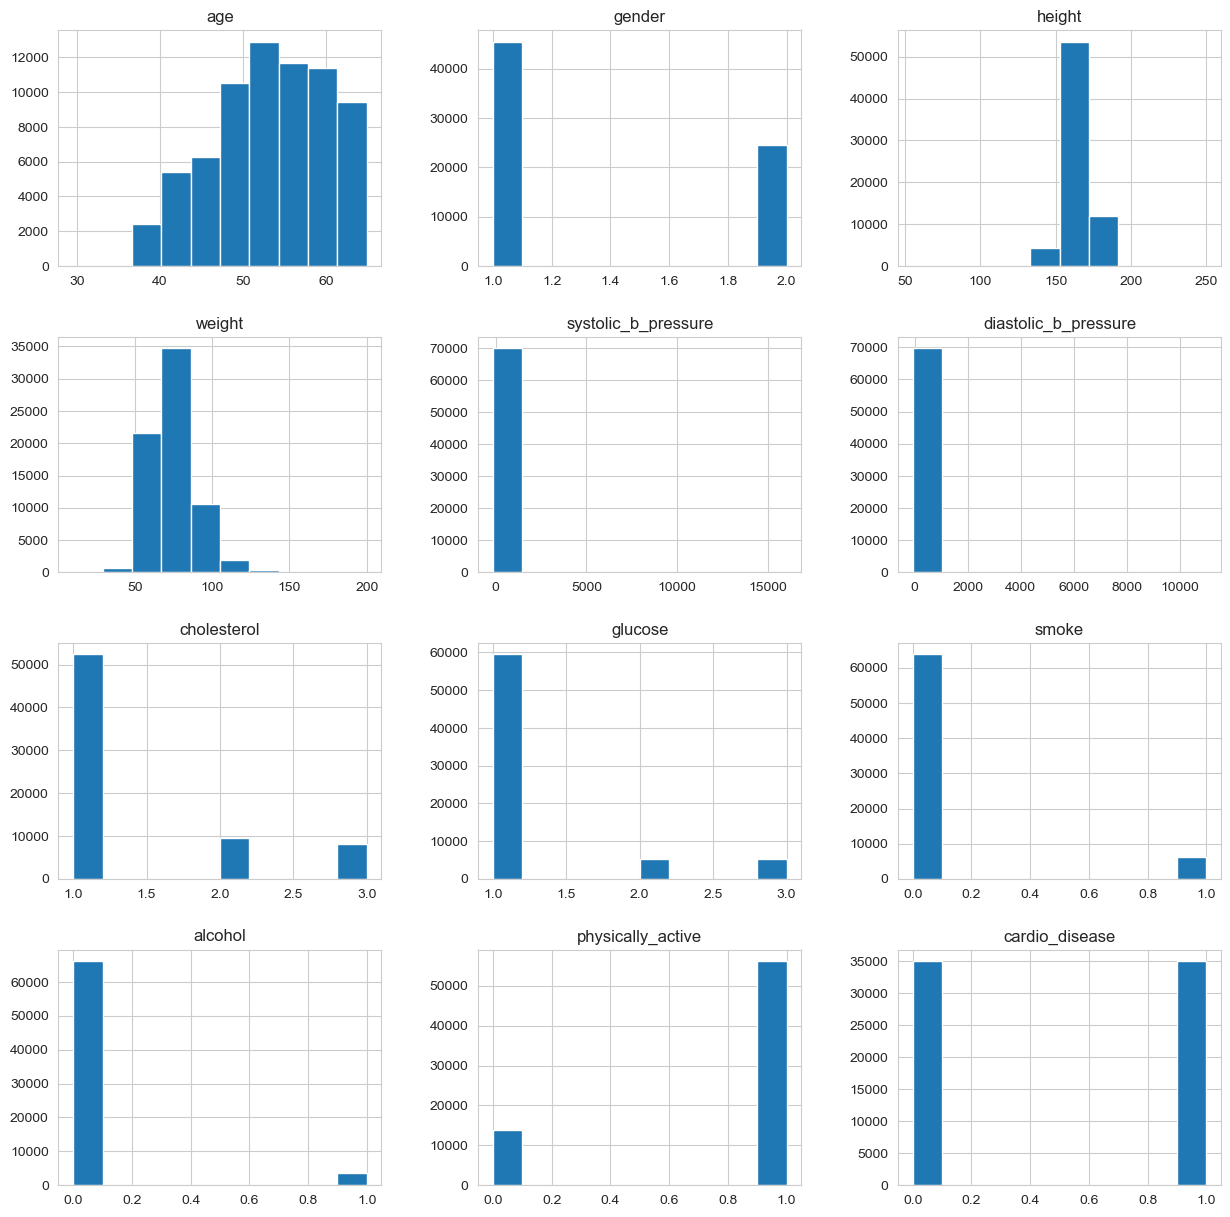

In [7]:
#数据框中所有数值列（除了第一列）的直方图
data.iloc[:,1:].hist(figsize=(15,15));

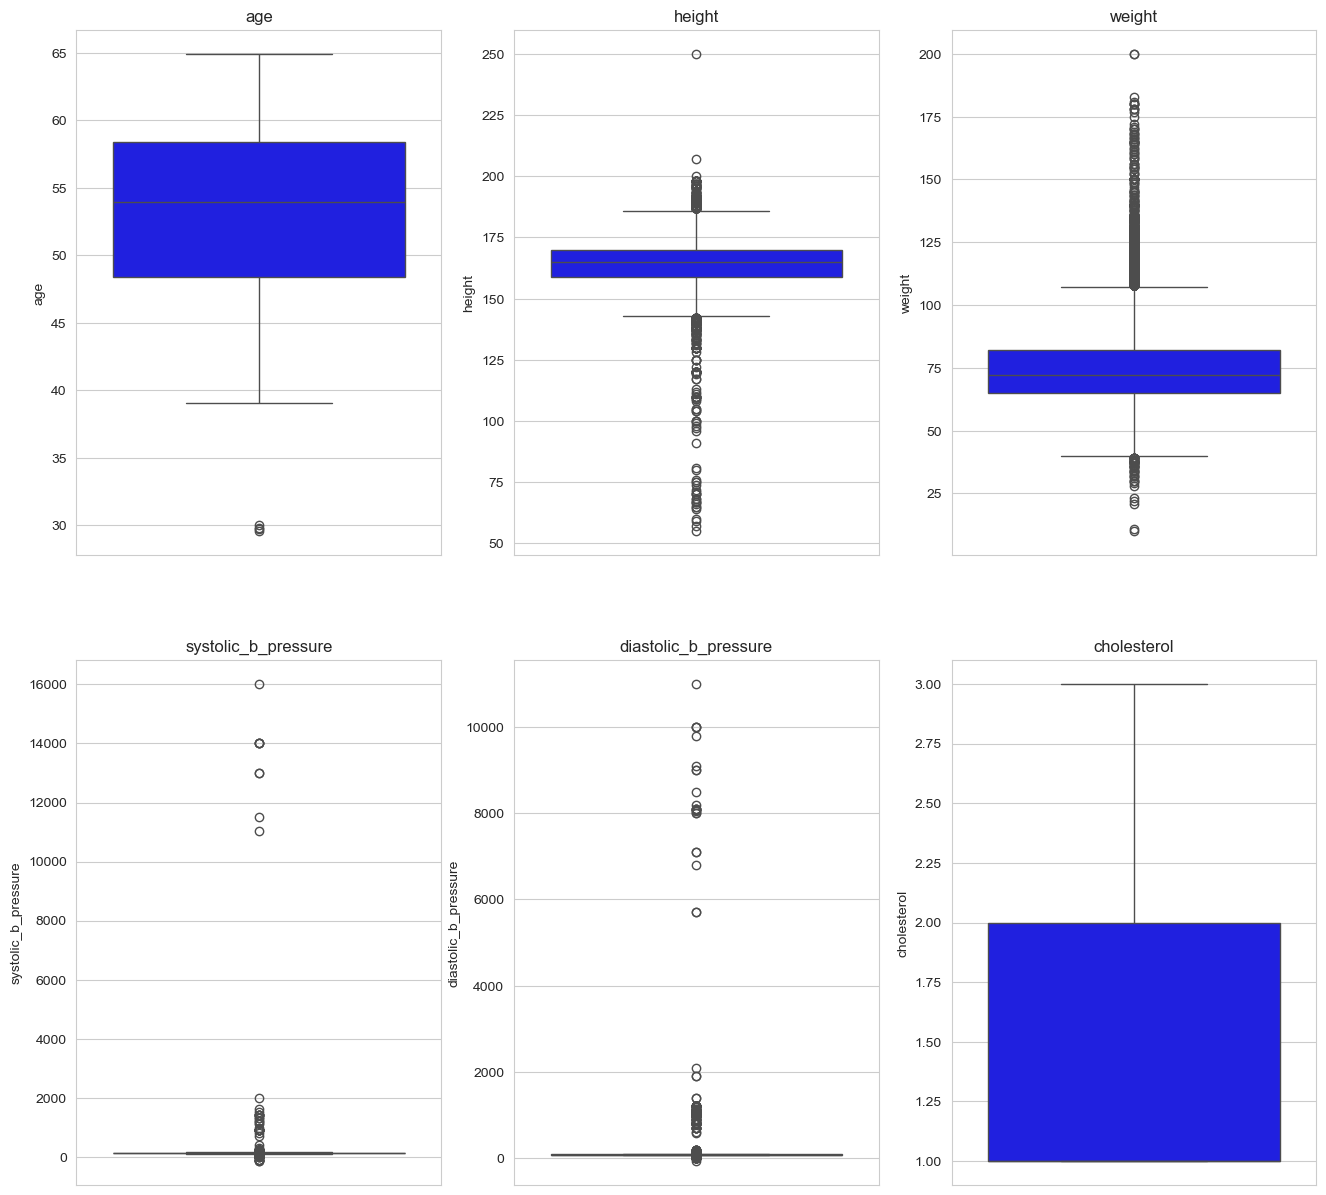

In [8]:
# 连续数据的箱型图
# Display the distribution of the continuous data columns
cols = ['age', 'height', 'weight', 'systolic_b_pressure', 'diastolic_b_pressure', 'cholesterol']
ncols = 3
nrows = 2

fig, ax = plt.subplots(nrows, ncols, figsize=(16, 15))

cont = 0
for i in range(nrows):
    for j in range(ncols):
        sns.boxplot(data[cols[cont]], ax=ax[i][j], color='blue')
        ax[i][j].set_title(cols[cont])
        cont = cont + 1

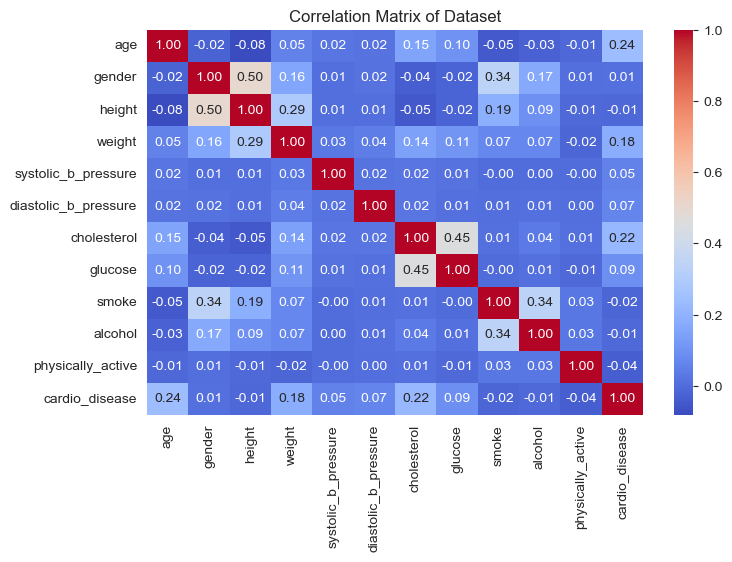

In [9]:
# Display Correlation matrix of the columns
# Create a correlation matrix
corr_matrix = data[['age', 'gender', 'height', 'weight', 'systolic_b_pressure', 
                     'diastolic_b_pressure', 'cholesterol', 'glucose', 'smoke', 'alcohol', 
                     'physically_active', 'cardio_disease']].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Dataset');

In [10]:
#data cleaning
# 清洗身高
data = data[(data['height'] >= 100) & (data['height'] <= 200)]

# 清洗体重
data = data[(data['weight'] >= 40) & (data['weight'] <= 200)]

# 清洗收缩压和舒张压
data = data[(data['systolic_b_pressure'] >= 90) & (data['systolic_b_pressure'] <= 250)]
data = data[(data['diastolic_b_pressure'] >= 60) & (data['diastolic_b_pressure'] <= 150)]

# 清洗胆固醇和血糖
data = data[data['cholesterol'].isin([1, 2, 3])]
data = data[data['glucose'].isin([1, 2, 3])]

# 检查并删除缺失值
data = data.dropna()

# 清洗性别
data = data[data['gender'].isin([1, 2])]

In [11]:
print(data.describe())  # 检查数值型列的统计信息

                 id           age        gender        height        weight  \
count  68448.000000  68448.000000  68448.000000  68448.000000  68448.000000   
mean   49972.421035     53.294650      1.349170    164.412211     74.171147   
std    28849.378308      6.754375      0.476711      7.964460     14.273744   
min        0.000000     29.563313      1.000000    100.000000     40.000000   
25%    24997.750000     48.353183      1.000000    159.000000     65.000000   
50%    50012.500000     53.941136      1.000000    165.000000     72.000000   
75%    74873.250000     58.381930      2.000000    170.000000     82.000000   
max    99999.000000     64.922656      2.000000    198.000000    200.000000   

       systolic_b_pressure  diastolic_b_pressure   cholesterol       glucose  \
count         68448.000000          68448.000000  68448.000000  68448.000000   
mean            126.731855             81.398858      1.364876      1.225894   
std              16.607643              9.399236

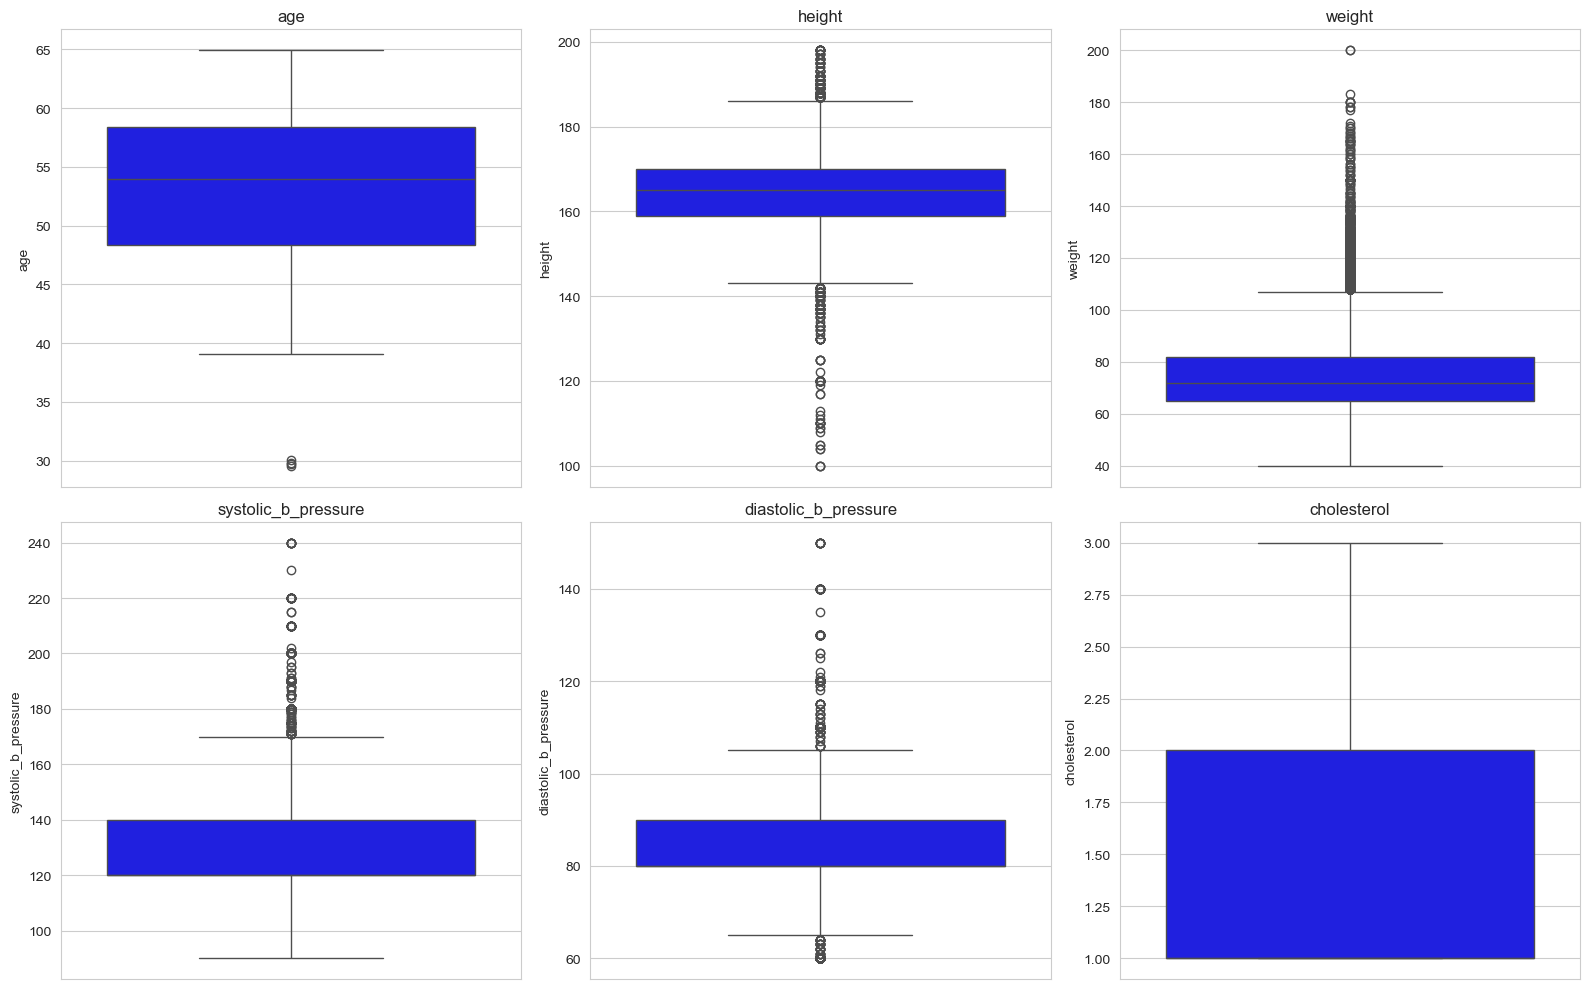

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制箱型图
cols = ['age', 'height', 'weight', 'systolic_b_pressure', 'diastolic_b_pressure', 'cholesterol']
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for i, col in enumerate(cols):
    sns.boxplot(data[col], ax=ax[i // 3][i % 3], color='blue')
    ax[i // 3][i % 3].set_title(col)

plt.tight_layout()
plt.show()

In [13]:
#Creating New Features
# 计算 BMI
data['bmi'] = data['weight'] / (data['height'] / 100) ** 2

# 血压分组
conditions = [
    (data['systolic_b_pressure'] < 120) & (data['diastolic_b_pressure'] < 80),
    ((data['systolic_b_pressure'] >= 120) & (data['systolic_b_pressure'] < 140)) |
    ((data['diastolic_b_pressure'] >= 80) & (data['diastolic_b_pressure'] < 90)),
    (data['systolic_b_pressure'] >= 140) | (data['diastolic_b_pressure'] >= 90)
]
categories = ['normal', 'prehypertension', 'hypertension']
data['blood_pressure_category'] = pd.cut(
    data['systolic_b_pressure'], bins=[0, 120, 140, float('inf')], labels=categories)

# 年龄分组
bins = [30, 45, 60, 80]
labels = ['young', 'middle_aged', 'elderly']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# 吸烟与饮酒交互
data['smoke_and_alcohol'] = ((data['smoke'] == 1) & (data['alcohol'] == 1)).astype(int)

# 收缩压与舒张压比值
data['pressure_ratio'] = data['systolic_b_pressure'] / data['diastolic_b_pressure']

# 胆固醇与 BMI 的交互
data['cholesterol_bmi_interaction'] = data['cholesterol'] * data['bmi']

# 身高与体重的比率
data['height_weight_ratio'] = data['height'] / data['weight']

# 身体活动与疾病交互
data['active_with_disease'] = ((data['physically_active'] == 1) & (data['cardio_disease'] == 1)).astype(int)

# 检查新特征
print(data.head())

   id        age  gender  height  weight  systolic_b_pressure  \
0   0  50.357290       2     168    62.0                  110   
1   1  55.381246       1     156    85.0                  140   
2   2  51.627652       1     165    64.0                  130   
3   3  48.249144       2     169    82.0                  150   
4   4  47.841205       1     156    56.0                  100   

   diastolic_b_pressure  cholesterol  glucose  smoke  ...  physically_active  \
0                    80            1        1      0  ...                  1   
1                    90            3        1      0  ...                  1   
2                    70            3        1      0  ...                  0   
3                   100            1        1      0  ...                  1   
4                    60            1        1      0  ...                  0   

   cardio_disease        bmi  blood_pressure_category    age_group  \
0               0  21.967120                   normal  mid

In [14]:
# 选择新增特征列
new_features = ['bmi', 'pressure_ratio', 'cholesterol_bmi_interaction', 
                'height_weight_ratio', 'active_with_disease']

# 查看每个新增特征的统计信息
data[new_features].describe()

,bmi,pressure_ratio,cholesterol_bmi_interaction,height_weight_ratio,active_with_disease
count,68448.000000,68448.000000,68448.000000,68448.000000,68448.000000
mean,27.488241,1.560969,38.127251,2.287216,0.390515
std,5.345211,0.146059,22.506134,0.390903,0.487869
min,13.520822,0.600000,13.520822,0.630303,0.000000
25%,23.875115,1.500000,24.242424,2.022727,0.000000
50%,26.346494,1.500000,27.990363,2.293333,0.000000
75%,30.119376,1.625000,42.822422,2.538462,1.000000
max,152.551775,3.250000,441.013314,4.300000,1.000000


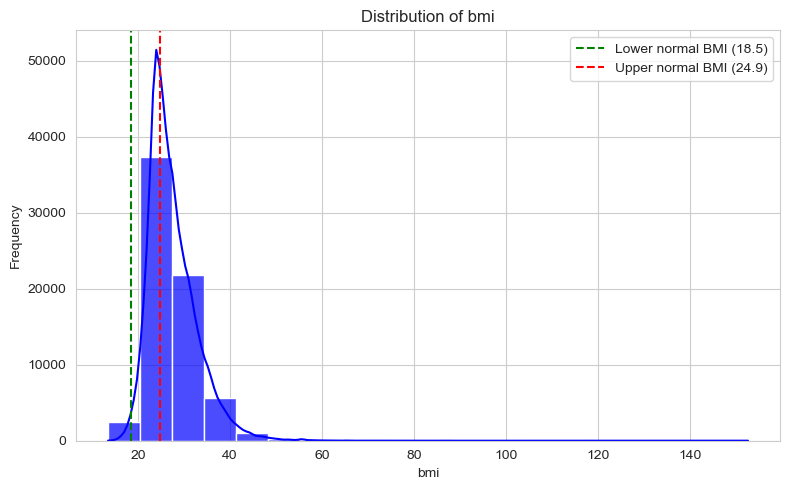

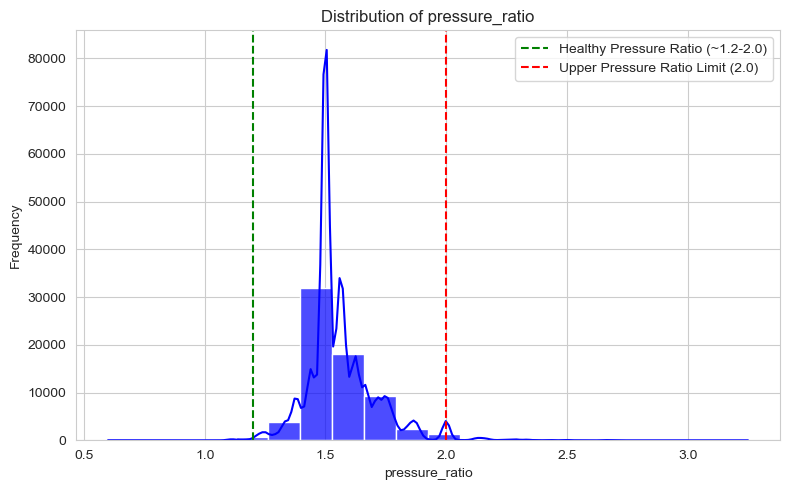

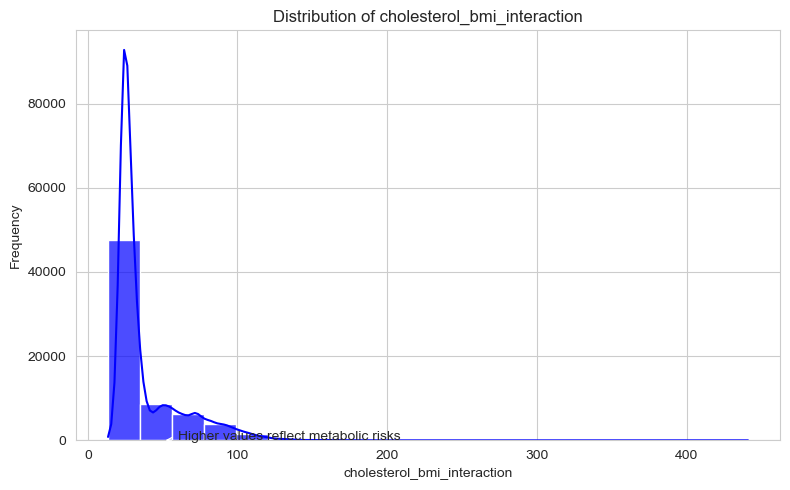

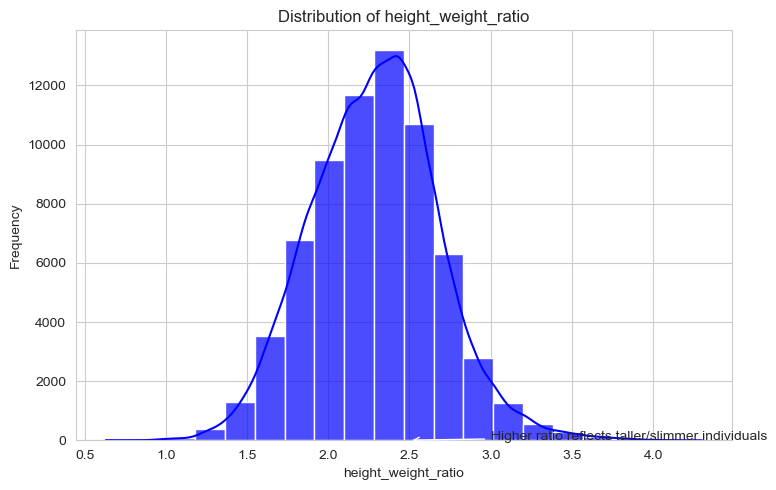

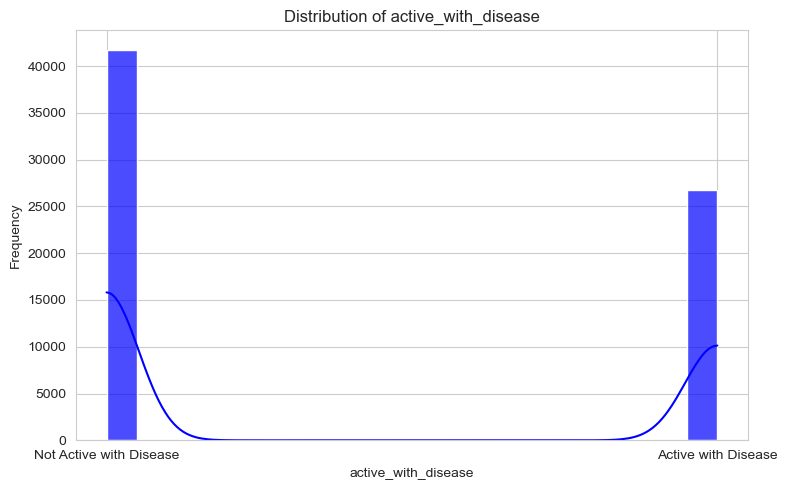

In [15]:
# 为每个新增特征绘制单独的分布图并添加注释
for feature in new_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(data[feature], kde=True, bins=20, color="blue", alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # 添加注释说明数据特征
    if feature == 'bmi':
        plt.axvline(x=18.5, color='green', linestyle='--', label='Lower normal BMI (18.5)')
        plt.axvline(x=24.9, color='red', linestyle='--', label='Upper normal BMI (24.9)')
        plt.legend()
    elif feature == 'pressure_ratio':
        plt.axvline(x=1.2, color='green', linestyle='--', label='Healthy Pressure Ratio (~1.2-2.0)')
        plt.axvline(x=2.0, color='red', linestyle='--', label='Upper Pressure Ratio Limit (2.0)')
        plt.legend()
    elif feature == 'cholesterol_bmi_interaction':
        plt.annotate('Higher values reflect metabolic risks',
                     xy=(50, 5), xytext=(60, 10),
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
    elif feature == 'height_weight_ratio':
        plt.annotate('Higher ratio reflects taller/slimmer individuals',
                     xy=(2.5, 5), xytext=(3, 10),
                     arrowprops=dict(facecolor='black', arrowstyle='->'))
    elif feature == 'active_with_disease':
        plt.xticks([0, 1], ['Not Active with Disease', 'Active with Disease'])
    
    plt.tight_layout()
    plt.show()

1. BMI（身体质量指数） 分布概述：
数据主要集中在 22 到 30 的范围内。 超过正常 BMI 上限（24.9）的样本数量不少，表明样本中存在一定比例的超重或肥胖个体。 绿色虚线（18.5）和红色虚线（24.9）标注了正常 BMI 的下限和上限。 可能意义：

BMI 是心血管疾病的关键指标。超重（BMI ≥ 25）或肥胖（BMI ≥ 30）通常与更高的心血管疾病风险相关。 分布说明样本中可能有较高比例的超重或肥胖人群，这为分析疾病风险提供了依据。

2. Pressure Ratio（收缩压与舒张压比值） 分布概述：
数据集中在 1.4 到 1.8 之间。 绿色虚线标注了健康范围的下限（1.2），红色虚线标注了上限（2.0）。 极少数样本比值超过 2.0，可能反映了异常血压状况。 可能意义：

收缩压与舒张压的比值是评估血管健康的重要指标。较高的比值可能暗示动脉僵硬或其他异常。 样本分布表明大多数个体的血压比值处于正常范围，少数可能处于高血压状态。

3. Cholesterol-BMI Interaction（胆固醇与 BMI 的交互） 分布概述：
数据呈现离散分布，主要集中在 20 到 100 之间。 高值（>80）可能对应 BMI 和胆固醇同时较高的个体。 可能意义：

胆固醇与 BMI 的交互特征可能揭示代谢异常。例如： 高胆固醇 + 高 BMI：可能指代肥胖伴随胆固醇异常，显著增加心血管疾病风险。 正常 BMI + 高胆固醇：可能是饮食或遗传导致的单纯胆固醇异常。

4. Height-Weight Ratio（身高与体重的比率） 分布概述：
数据集中在 1.8 到 2.8 之间。 比率较高（>2.5）的样本可能对应较高身高和较低体重的个体，反映瘦长体型。 比率较低的个体可能体型较矮或较重。 可能意义：

身高和体重的比率补充了 BMI 的信息： 高比率：可能与健康体型相关（如瘦长）。 低比率：可能与较矮或较重的体型相关，需结合 BMI 进一步分析。

5. Active with Disease（身体活跃且患病） 分布概述：
二值特征，取值为 0 或 1。 样本中 0 的数量远多于 1，说明大多数个体要么不活跃，要么未患病。 1 对应“身体活跃但患有疾病”的状态，比例较少。 可能意义：

这一特征可以用来分析身体活动和疾病状态的关系： 是否身体活跃的人群仍然患有心血管疾病？ 活跃状态是否与疾病严重程度无关？

蓝色直方图： 直方图显示了数据分布的频率。 每个柱状条的高度表示该区间内数据的样本数量。 例如，对于 BMI，某一柱状条可能表示有 50 个样本的 BMI 在 22 到 23 之间。
蓝色密度曲线（KDE）： 蓝色的密度曲线是直方图的平滑估计，用于显示数据分布的趋势。 它是一种概率密度函数，表示在每个值附近观察到数据点的可能性。 例如： 对于 Pressure Ratio，密度曲线的峰值可能在 1.5 附近，表示该比值的数据集中程度最高。
如何理解蓝线（KDE）？ 蓝线（密度曲线）帮助我们理解数据的集中趋势和分布形状，而不是仅依赖直方图。 它能直观地展示： 数据是否符合正态分布（钟形曲线）。 是否存在偏态（数据分布不对称）。 是否有多模分布（多个峰值）。
总结 蓝色直方图：表示每个区间的样本数量（离散分布）。 蓝色密度曲线：表示数据分布的趋势（连续估计）。

In [16]:
# 检查非数值列
non_numeric_columns = data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# 对非数值列进行 One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=non_numeric_columns, drop_first=True)

# 重新计算相关性矩阵
correlation_matrix_encoded = data_encoded.corr()

# 提取所有特征与目标变量 'cardio_disease' 的相关性
correlation_with_target_all_encoded = correlation_matrix_encoded['cardio_disease'].sort_values(ascending=False)

# 输出所有特征与目标变量的相关性
print("Correlation of all features with cardio_disease (after encoding):")
print(correlation_with_target_all_encoded)

Non-numeric columns: Index(['blood_pressure_category', 'age_group'], dtype='object')
Correlation of all features with cardio_disease (after encoding):
cardio_disease                             1.000000
active_with_disease                        0.807764
systolic_b_pressure                        0.426942
diastolic_b_pressure                       0.341607
blood_pressure_category_hypertension       0.284591
blood_pressure_category_prehypertension    0.251802
cholesterol_bmi_interaction                0.250103
age                                        0.239101
cholesterol                                0.221180
bmi                                        0.185897
weight                                     0.179265
pressure_ratio                             0.174184
age_group_elderly                          0.162605
glucose                                    0.089529
gender                                     0.006963
id                                         0.003823
age_group_middle_

In [17]:
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Index: 68448 entries, 0 to 69999
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   id                                       68448 non-null  int64  
 1   age                                      68448 non-null  float64
 2   gender                                   68448 non-null  int64  
 3   height                                   68448 non-null  int64  
 4   weight                                   68448 non-null  float64
 5   systolic_b_pressure                      68448 non-null  int64  
 6   diastolic_b_pressure                     68448 non-null  int64  
 7   cholesterol                              68448 non-null  int64  
 8   glucose                                  68448 non-null  int64  
 9   smoke                                    68448 non-null  int64  
 10  alcohol                                  68448 non-

In [18]:
print(data.shape)  # 原始数据框
print(data_encoded.shape)  # 编码后的数据框

(68448, 21)
(68448, 23)


In [19]:
for col in data_encoded.columns:
    print(f"Correlation of {col} with cardio_disease: {data_encoded[col].corr(data_encoded['cardio_disease'])}")

Correlation of id with cardio_disease: 0.003822590547719177
Correlation of age with cardio_disease: 0.23910114914620934
Correlation of gender with cardio_disease: 0.00696277444423107
Correlation of height with cardio_disease: -0.013190748747041785
Correlation of weight with cardio_disease: 0.1792653636679319
Correlation of systolic_b_pressure with cardio_disease: 0.4269421941728022
Correlation of diastolic_b_pressure with cardio_disease: 0.34160678918278714
Correlation of cholesterol with cardio_disease: 0.22118044999303613
Correlation of glucose with cardio_disease: 0.08952910451336529
Correlation of smoke with cardio_disease: -0.01595522877778987
Correlation of alcohol with cardio_disease: -0.007777884776192955
Correlation of physically_active with cardio_disease: -0.038024533869494274
Correlation of cardio_disease with cardio_disease: 1.0
Correlation of bmi with cardio_disease: 0.18589718566559385
Correlation of smoke_and_alcohol with cardio_disease: -0.018022740204239367
Correlatio

In [21]:
#1. 对连续变量进行标准化
#将连续变量（如血压、BMI、体重等）标准化，以消除量级的影响。
from sklearn.preprocessing import StandardScaler

# 对数值型列进行标准化
numeric_cols = data_encoded.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data_encoded[numeric_cols] = scaler.fit_transform(data_encoded[numeric_cols])

In [22]:
#2. 使用特征重要性方法
#利用模型嵌入法随机森林计算特征的重要性，避免仅依赖相关性：
from sklearn.ensemble import RandomForestClassifier

# 确保目标变量为整数类型
y = data_encoded['cardio_disease'].astype(int)
X = data_encoded.drop(columns=['cardio_disease'])

# 随机森林模型
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# 输出特征重要性
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importances)

                                    Feature  Importance
17                      active_with_disease    0.515369
11                        physically_active    0.107482
5                       systolic_b_pressure    0.069924
1                                       age    0.041633
15              cholesterol_bmi_interaction    0.036273
6                      diastolic_b_pressure    0.030299
0                                        id    0.028841
19     blood_pressure_category_hypertension    0.024454
12                                      bmi    0.024133
16                      height_weight_ratio    0.023313
4                                    weight    0.018368
3                                    height    0.017984
18  blood_pressure_category_prehypertension    0.017239
14                           pressure_ratio    0.015568
7                               cholesterol    0.009480
21                        age_group_elderly    0.005264
8                                   glucose    0

In [23]:
# 计算特征之间的相关性
corr_matrix = data_encoded.corr()

# 查看高度相关的特征
high_corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
print(high_corr_pairs[high_corr_pairs > 0.8])  # 高于 0.8 的相关性

id                                       id                                         1.000000
cardio_disease                           cardio_disease                             1.000000
height                                   height                                     1.000000
weight                                   weight                                     1.000000
systolic_b_pressure                      systolic_b_pressure                        1.000000
diastolic_b_pressure                     diastolic_b_pressure                       1.000000
cholesterol                              cholesterol                                1.000000
glucose                                  glucose                                    1.000000
smoke                                    smoke                                      1.000000
alcohol                                  alcohol                                    1.000000
bmi                                      bmi                          

In [24]:
# 删除冗余特征
data_encoded.drop(columns=['height_weight_ratio', 'weight', 'cholesterol', 'pressure_ratio'], inplace=True)

# 检查剩余特征
print(data_encoded.columns)

Index(['id', 'age', 'gender', 'height', 'systolic_b_pressure',
       'diastolic_b_pressure', 'glucose', 'smoke', 'alcohol',
       'physically_active', 'cardio_disease', 'bmi', 'smoke_and_alcohol',
       'cholesterol_bmi_interaction', 'active_with_disease',
       'blood_pressure_category_prehypertension',
       'blood_pressure_category_hypertension', 'age_group_middle_aged',
       'age_group_elderly'],
      dtype='object')


In [25]:
# 训练随机森林模型
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# 输出特征重要性
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(importances)

                                    Feature  Importance
17                      active_with_disease    0.515369
11                        physically_active    0.107482
5                       systolic_b_pressure    0.069924
1                                       age    0.041633
15              cholesterol_bmi_interaction    0.036273
6                      diastolic_b_pressure    0.030299
0                                        id    0.028841
19     blood_pressure_category_hypertension    0.024454
12                                      bmi    0.024133
16                      height_weight_ratio    0.023313
4                                    weight    0.018368
3                                    height    0.017984
18  blood_pressure_category_prehypertension    0.017239
14                           pressure_ratio    0.015568
7                               cholesterol    0.009480
21                        age_group_elderly    0.005264
8                                   glucose    0

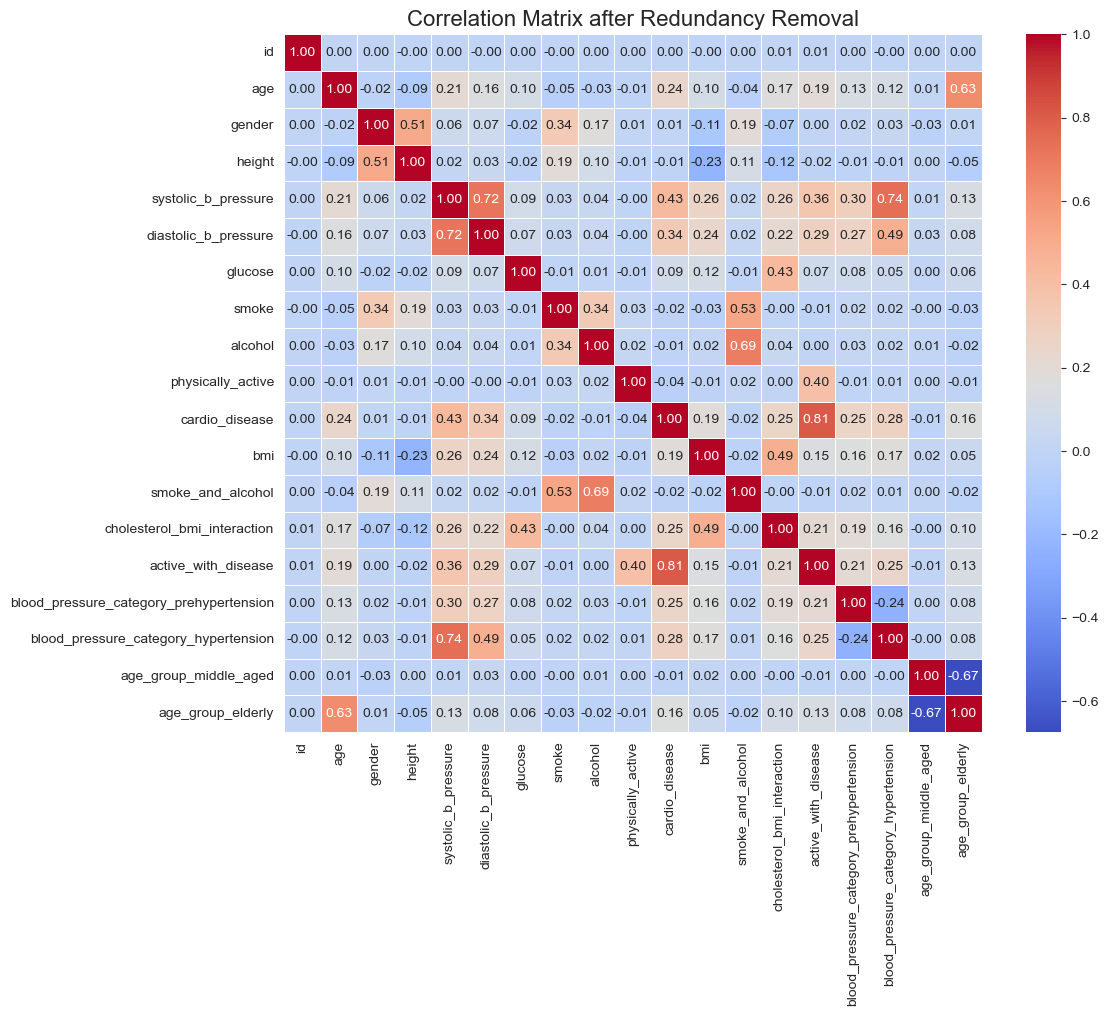

In [26]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Re-draw the correlation matrix with better visualization settings
plt.figure(figsize=(12, 10))
sns.heatmap(data_encoded.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=0.5)
plt.title('Correlation Matrix after Redundancy Removal', fontsize=16)
plt.tight_layout()
plt.show()

In [27]:
# 检查 data_encoded 的列名
print("Current columns in data_encoded:")
print(data_encoded.columns)

# 修正 features_to_drop
features_to_drop = [
    'gender', 'smoke', 'alcohol', 'physically_active', 
     'pressure_ratio', 'weight', 'height_weight_ratio', 'cholesterol'
]

# 确保删除的列存在于数据框中
features_to_drop = [col for col in features_to_drop if col in data_encoded.columns]
print("Features to drop:", features_to_drop)

# 删除存在的特征
data_encoded_cleaned = data_encoded.drop(columns=features_to_drop)

# 检查剩余特征
print("Remaining features after cleaning:")
print(data_encoded_cleaned.columns)

Current columns in data_encoded:
Index(['id', 'age', 'gender', 'height', 'systolic_b_pressure',
       'diastolic_b_pressure', 'glucose', 'smoke', 'alcohol',
       'physically_active', 'cardio_disease', 'bmi', 'smoke_and_alcohol',
       'cholesterol_bmi_interaction', 'active_with_disease',
       'blood_pressure_category_prehypertension',
       'blood_pressure_category_hypertension', 'age_group_middle_aged',
       'age_group_elderly'],
      dtype='object')
Features to drop: ['gender', 'smoke', 'alcohol', 'physically_active']
Remaining features after cleaning:
Index(['id', 'age', 'height', 'systolic_b_pressure', 'diastolic_b_pressure',
       'glucose', 'cardio_disease', 'bmi', 'smoke_and_alcohol',
       'cholesterol_bmi_interaction', 'active_with_disease',
       'blood_pressure_category_prehypertension',
       'blood_pressure_category_hypertension', 'age_group_middle_aged',
       'age_group_elderly'],
      dtype='object')


In [28]:
print("Columns in data_encoded_cleaned:")
print(data_encoded_cleaned.columns)

Columns in data_encoded_cleaned:
Index(['id', 'age', 'height', 'systolic_b_pressure', 'diastolic_b_pressure',
       'glucose', 'cardio_disease', 'bmi', 'smoke_and_alcohol',
       'cholesterol_bmi_interaction', 'active_with_disease',
       'blood_pressure_category_prehypertension',
       'blood_pressure_category_hypertension', 'age_group_middle_aged',
       'age_group_elderly'],
      dtype='object')


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 确保删除 'id' 和 'cardio_disease' 列
X = data_encoded_cleaned.drop(columns=['id', 'cardio_disease'])
y = data_encoded_cleaned['cardio_disease']

# 修正特征列表
numeric_features = [
    'age', 'height', 'systolic_b_pressure', 'diastolic_b_pressure', 'glucose', 
    'bmi', 'cholesterol_bmi_interaction', 'active_with_disease'
]

categorical_features = [
    'blood_pressure_category_prehypertension', 
    'blood_pressure_category_hypertension', 
    'age_group_middle_aged', 
    'age_group_elderly'
]

# 确保所有特征都在数据中
numeric_features = [col for col in numeric_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

# 创建预处理器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # 数值型特征标准化
        ('cat', OneHotEncoder(drop='first'), categorical_features)  # 类别型特征独热编码
    ]
)

# 确保 y 被正确转换为整数类型
y = y.astype(int)

# 应用预处理器并分割数据集
try:
    X_transformed = preprocessor.fit_transform(X)  # 对 X 应用预处理器
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

    # 输出分割后数据的形状
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

except ValueError as e:
    print("Error during preprocessing:", e)

X_train shape: (54758, 12)
X_test shape: (13690, 12)
y_train shape: (54758,)
y_test shape: (13690,)


In [31]:
from sklearn.linear_model import LogisticRegression
# 
# # 创建管道（在模型训练前）
# full_pipeline = Pipeline([
#     ('preprocessor', preprocessor),  # 已定义的ColumnTransformer
#     ('model', LogisticRegression(max_iter=1000))  # 模型
# ])
# 
# # 训练管道
# full_pipeline.fit(X_train, y_train)  # 注意此处应使用X_train而非

# load and train the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

# # 保存模型
from joblib import dump
dump(lr, 'logistic_regression_model.joblib')
print("模型已保存为 'logistic_regression_model.joblib'")

# dump(full_pipeline, 'full_pipeline.joblib')  # 保存包含预处理的完整管道

# Display the train and test scores
print('Train Accuracy: ',lr.score(X_train,y_train))
print('Test Accuracy: ', lr.score(X_test,y_test))

模型已保存为 'logistic_regression_model.joblib'
Train Accuracy:  0.8972022352898207
Test Accuracy:  0.8942293644996347


In [32]:
# 加载模型并进行预测
from joblib import load
loaded_model = load('logistic_regression_model.joblib')
predictions = loaded_model.predict(X_test)
print("测试集的预测结果:", predictions)

测试集的预测结果: [1 0 0 ... 1 1 0]


In [34]:
# 导入必要的库
from joblib import load
import numpy as np

# 加载保存的模型
model_path = 'logistic_regression_model.joblib'
loaded_model = load(model_path)

# 使用加载的模型进行预测
# 预测类别（0 或 1）
y_pred = loaded_model.predict(X_test)
print("预测类别:\n", y_pred)

# 预测概率（每个样本属于类别 0 和类别 1 的概率）
y_pred_proba = loaded_model.predict_proba(X_test)
print("预测概率:\n", y_pred_proba)

# 输出每个样本患病的概率（类别 1 的概率）
disease_probability = y_pred_proba[:, 1]
print("每个样本患病的概率:\n", disease_probability)

# 输出前 5 个样本的预测结果
for i in range(20):
    print(f"样本 {i+1}: 预测类别 = {y_pred[i]}, 患病概率 = {disease_probability[i]:.4f}")

预测类别:
 [1 0 0 ... 1 1 0]
预测概率:
 [[4.55386157e-05 9.99954461e-01]
 [9.55989776e-01 4.40102242e-02]
 [9.17693968e-01 8.23060324e-02]
 ...
 [5.22492497e-05 9.99947751e-01]
 [9.10909536e-05 9.99908909e-01]
 [9.45867487e-01 5.41325130e-02]]
每个样本患病的概率:
 [0.99995446 0.04401022 0.08230603 ... 0.99994775 0.99990891 0.05413251]
样本 1: 预测类别 = 1, 患病概率 = 1.0000
样本 2: 预测类别 = 0, 患病概率 = 0.0440
样本 3: 预测类别 = 0, 患病概率 = 0.0823
样本 4: 预测类别 = 0, 患病概率 = 0.0972
样本 5: 预测类别 = 0, 患病概率 = 0.0595
样本 6: 预测类别 = 0, 患病概率 = 0.3604
样本 7: 预测类别 = 1, 患病概率 = 1.0000
样本 8: 预测类别 = 1, 患病概率 = 0.9999
样本 9: 预测类别 = 0, 患病概率 = 0.1629
样本 10: 预测类别 = 1, 患病概率 = 1.0000
样本 11: 预测类别 = 0, 患病概率 = 0.1503
样本 12: 预测类别 = 0, 患病概率 = 0.3259
样本 13: 预测类别 = 1, 患病概率 = 1.0000
样本 14: 预测类别 = 0, 患病概率 = 0.1422
样本 15: 预测类别 = 0, 患病概率 = 0.2786
样本 16: 预测类别 = 0, 患病概率 = 0.0413
样本 17: 预测类别 = 0, 患病概率 = 0.3334
样本 18: 预测类别 = 1, 患病概率 = 0.9999
样本 19: 预测类别 = 0, 患病概率 = 0.0589
样本 20: 预测类别 = 0, 患病概率 = 0.0388
